In [2]:
from IPython.display import display, clear_output
import numpy as np
from scipy import signal
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import ipywidgets as ipw
import os
import trackpy as tp
from ipywidgets import interact
import ipywidgets as widgets
from PIL import Image
from torchvision import transforms

%config InlineBackend.figure_format = 'retina'  
plt.rcParams.update({'font.size': 9,
                     'axes.titlesize': 9,
                     'axes.labelsize': 9,
                     'lines.linewidth': 1,
                     'lines.markersize': 5,
                     'xtick.labelsize' : 9,
                     'ytick.labelsize' : 9,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'axes.labelpad': 0,
                     'legend.fontsize': 10,}) 

In [3]:
class TDMS_Video:
    def __init__(self, filename):
        self.tdms_file = TdmsFile.read(filename)
        self.props = dict(self.tdms_file.properties)
        self.dimx = int(self.props["dimx"])
        self.dimy = int(self.props["dimy"])
        self.frames = int(self.props["frames"])
        self.image_group = self.tdms_file['Image']
        self.image_channel = self.image_group['Image']
        self.images = self.image_channel.data.reshape([self.frames, self.dimx, self.dimy])

    def get_image(self, image_num):
        return self.images[image_num, :, :]

    def write_images(self, directory_name):
        os.makedirs(directory_name, exist_ok=True)
        for frame in range(self.frames):
            filename = os.path.join(directory_name, f"output_{frame:03}.png")
            plt.imsave(filename, self.images[frame, :, :], cmap="gray")

    def get_particle(self, image_num, pos, size):
        image = self.get_image(image_num)
        xp, yp = map(int, pos)
        xs, xe = max(0, xp - size - 1), xp + size
        ys, ye = max(0, yp - size - 1), yp + size
        return image[xs:xe, ys:ye]

    def loc_particles(self, image_num, dist=31, minmass=1e5, display=False):
        image = self.get_image(image_num)
        f = tp.locate(image, dist, invert=True, minmass=minmass)
        if display:
            tp.annotate(f, image)
        return f

In [4]:
import ipywidgets as widgets

# Get a list of .tdms files in the current directory
files = [f for f in os.listdir() if f.endswith('.tdms')]

class ParticleImages:
    def __init__(self):
        self.images = []
        self.progress = widgets.IntProgress(description='Loading:', min=0, max=1)  # initialize progress bar
        self.output = widgets.Output()  # output widget to display the progress bar

    def on_file_selected(self, change):
        self.images.clear()  # clear any previous images
        file = change['new']
        video = TDMS_Video(file)
        frames = video.frames

        # Update the maximum value and display the progress bar
        self.progress.max = frames
        with self.output:
            clear_output(wait=True)  # clear the previous progress bar
            display(self.progress)

        # Loop over each frame
        for frame in range(frames):
            # Locate particles in the current frame
            frame_particles = video.loc_particles(frame, dist=19)

            # Loop over each particle
            for _, (x, y, *_) in frame_particles.iterrows():
                particle_image = video.get_particle(frame, [x, y], 30)
                self.images.append(particle_image)

            # Update the progress bar
            self.progress.value = frame + 1

# Create an instance of ParticleImages
particle_images = ParticleImages()

dropdown = widgets.Dropdown(options=files, description='Select file:')
dropdown.observe(particle_images.on_file_selected, names='value')

box = widgets.VBox([dropdown, particle_images.output])
display(box)

In [5]:
def browse_images(images):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap='gray')
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(particle_images.images)

interactive(children=(IntSlider(value=403, description='i', max=806), Output()), _dom_classes=('widget-interac…

In [6]:
file=TDMS_Video(dropdown.value)

In [7]:
image=file.get_image(30)

In [8]:
image.shape

(1024, 1024)

In [11]:
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

dx = np.abs(signal.convolve2d(image, kernel_x, mode='same'))
dy = np.abs(signal.convolve2d(image, kernel_y, mode='same'))


In [1]:
mag = np.hypot(dx, dy)
mag = mag / np.max(mag) * 255
thres_mag=np.where(mag > 100, 255, 0)
plt.imshow(thres_mag, cmap='gray')
plt.show()

NameError: name 'np' is not defined

# Hough Transform for linear edges

Imagine you have an image which has objects with edges that are linear. Points of these edges then follow the equation

$$
y_i=a x_i+ b
$$

which lives in an image space coordinate system with {x,y}. This equation can be converted into a parameter space equation 

$$
b = x_i a+ y_i
$$

which means that the coordinates $x_i$ and $y_i$ of a single point become the slope and the offset of a line in the parameter space {a,b}.

Each point of a line in the image space now corresponds to a line in the parameter space.

In [33]:
def line(x,a,b):
    return a*x+b

In [175]:
def polar(x,y,theta):
    return x*np.cos(theta)+y*np.sin(theta)

Let us create some empty image to which we add some bright points that all lie on a line.

In [100]:
image=np.zeros([200,200])

In [170]:
x=np.random.rand(20)*200
y=line(x,1,5)
x=np.array(x,dtype=int)
y=np.array(y,dtype=int)
indices=np.array(list(zip(x,y)))
image[indices[:, 1], indices[:, 0]] = 255


Display the image

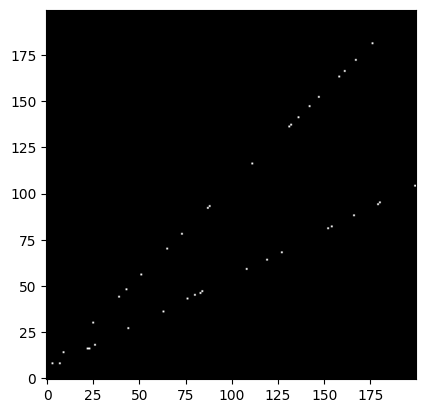

In [171]:
plt.imshow(image,cmap="gray",origin="lower")

The displayed image would in general correspond to a image to which some edge detection algorithm had been performed, i.e. the points at the edges are white and the image is thresholded.
We can the get back the coordinates of the points of all edges in the image by

In [172]:
xe,ye=np.where(image>100)

Each of these points $x_i,y_i$ now corresponds to a slope of a line in the parameter space $a,b$. We can therefore plot these lines.

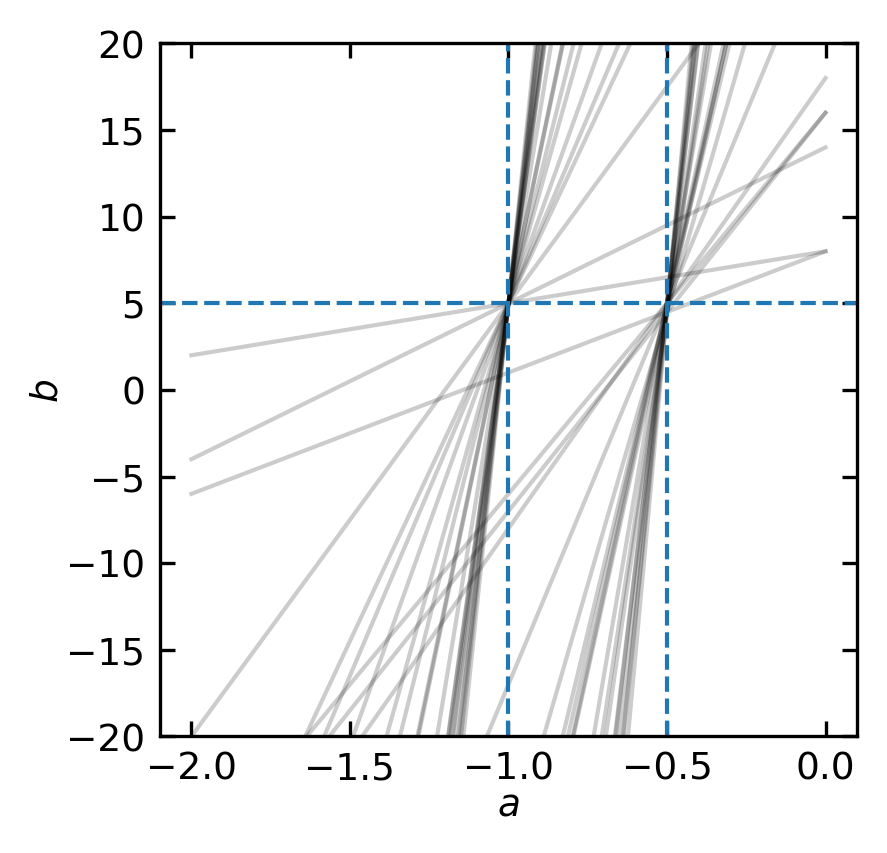

In [191]:
plt.figure(figsize=(3,3),dpi=150)
a=np.linspace(-2,0,10)
for xp,yp in list(zip(xe,ye)):
    b=line(a,yp,xp)
    
    plt.plot(a,b,'k-',alpha=0.2)

plt.ylim(-20,20)
plt.axhline(5,ls="--")
plt.axvline(-0.5,ls="--")
plt.axvline(-1,ls="--")
plt.xlabel(r"$a$")    
plt.ylabel(r"$b$")
plt.show()    


What becomes clear from this plot is that all the lines intersect in a point, which is here -0.5 and 5, actually corresponding to the parameters of the line in the image space.
If we construct an array representing the parameter space and accumulate the occurrences of line points in the array, we get a maximum at the intersection. Therefore finding these maxima allows to extract the parameters of the line in the image space. The array representing the parameter space is called the accumulator. 

The above example uses a simple parametrization of the line, which is however not really usful as we do not know the slope of the lines before. A better representation is in polar coordinates, i.e.

$$
\rho=x\cos(\theta)+y\sin(\theta)
$$

where $\rho$ is the closest distance of the line to the origin and $\theta$ is the angle of the line from the origin to a point of the line that is parametrized. In this case the parameter space is given by $\rho, \theta$ and the given shape for a specific $x_i,y_i$ is a sine or cosine function. 

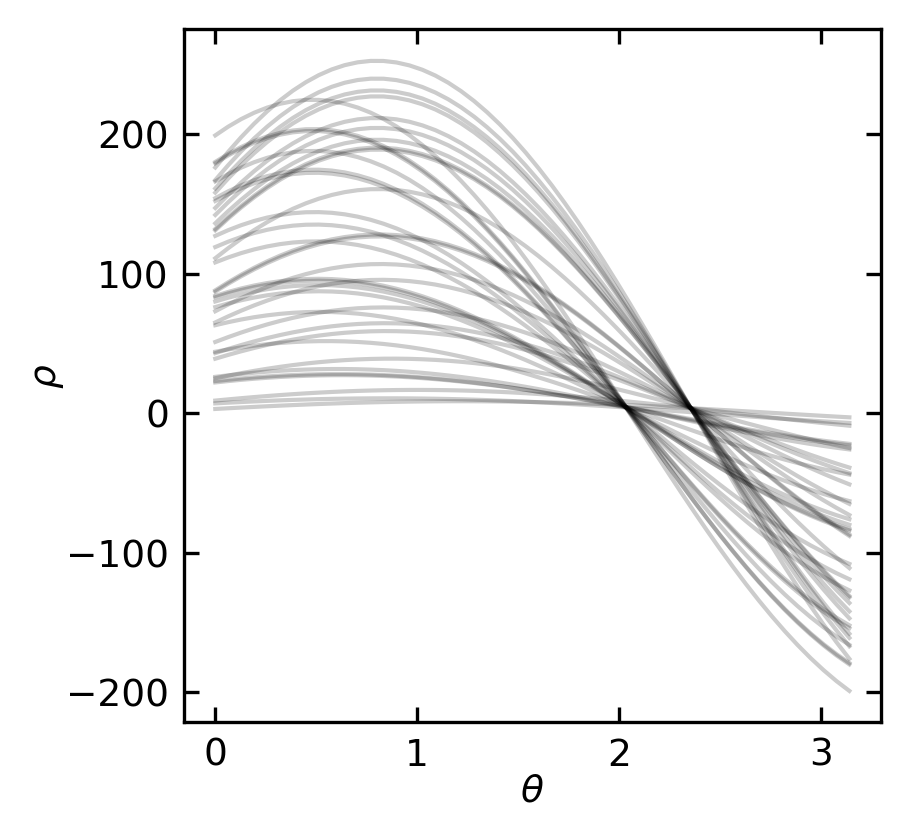

In [195]:
plt.figure(figsize=(3,3),dpi=150)
theta=np.linspace(0,np.pi,50)
for xp,yp in list(zip(xe,ye)):
    rho=polar(yp,xp,theta)
    
    plt.plot(theta,rho,'k-',alpha=0.2)

plt.xlabel(r"$\theta$")    
plt.ylabel(r"$\rho$")
plt.show()

Following this insight one can write a simple algorithm that corresponds to a Hough transform for a line. 

In [208]:
def hough_transform(image, theta_res=1, rho_res=1):
    height, width = image.shape
    diag_len = int(np.hypot(height, width))  # Maximum possible rho value
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))
    rhos = np.arange(-diag_len, diag_len, rho_res)
    cos_thetas = np.cos(thetas)
    sin_thetas = np.sin(thetas)
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint8)

    y_idxs, x_idxs = np.nonzero(image)  # Indices of edge points

    for i, x in enumerate(x_idxs):
        y = y_idxs[i]

        for t_idx, cos_theta in enumerate(cos_thetas):
            rho = int(round(x * cos_theta + y * sin_thetas[t_idx]) + diag_len)
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

In [209]:
accumulator, thetas, rhos = hough_transform(image)

In [210]:
threshold = 0.2 * np.max(accumulator)  # Adjust the threshold as needed
rho_idxs, theta_idxs = np.nonzero(accumulator > threshold)

lines = []
for rho_idx, theta_idx in zip(rho_idxs, theta_idxs):
    rho = rhos[rho_idx]
    theta = thetas[theta_idx]
    lines.append((rho, theta))

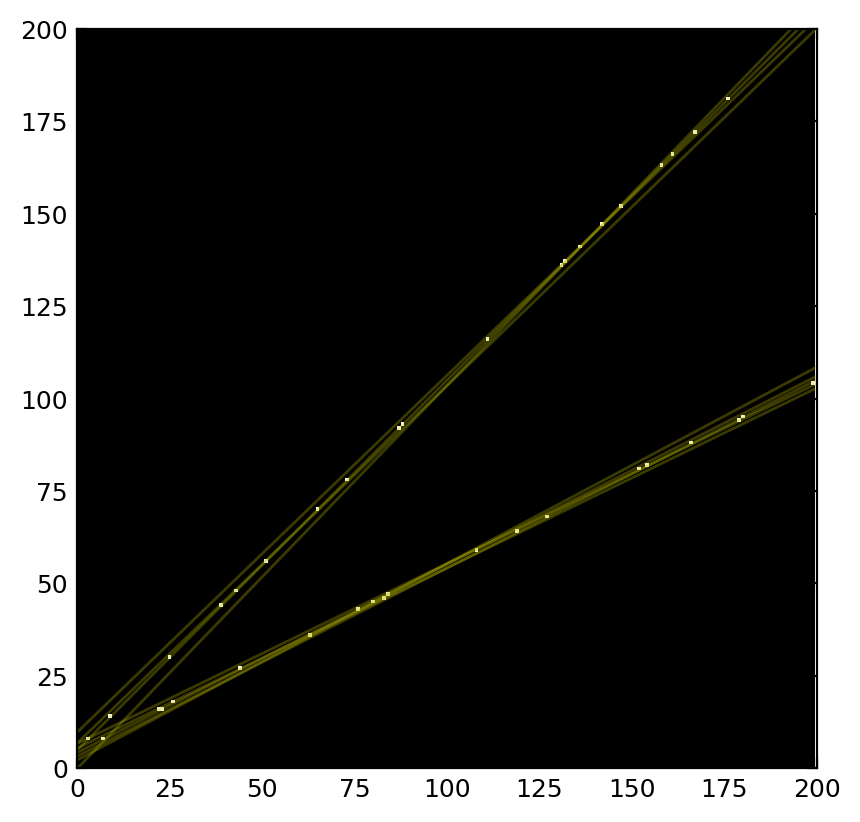

In [211]:
fig, ax = plt.subplots()
ax.imshow(image,cmap="gray")

for rho, theta in lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    ax.plot([x1, x2], [y1, y2], 'y',alpha=0.3)
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()